In [2]:
import numpy as np
from scipy.fft import fft, dct, idct
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
x = np.random.randn(84,120)
x.shape

(84, 120)

In [4]:
x.shape[0]

84

In [5]:
def dct2(x, norm=None):
    N = len(x)
    n = np.arange(N)

    coeff_vec = []
    
    for k in n:
        yk = 0
        for i in n:
            yk += x[i] * np.cos(np.pi* k*(2*i + 1)/(2*N))
        if norm=='ortho':
            if k == 0:
                yk = np.sqrt(1/(4*N)) * yk
            else:
                yk = np.sqrt(1/(2*N)) * yk
        yk = yk*2
#         print(yk)
        coeff_vec.append(yk)
        
    return np.array(coeff_vec)

In [6]:
def dct_mat(x):
    L = x.shape[-1]
    C = np.zeros((L,L))
    n = k = np.arange(L)
#     k = np.arange(1,L)
#     print(C.shape)
#     for k in range(L):
#         for n in range(L):
#             if k == 0:

# #             else:
    for _k in k[1:]:
        C[_k,n] = np.sqrt(2/L)*np.cos((np.pi*_k*(1/2+n))/L)
    
    C[0,:] = np.sqrt(1/L)
#     print("C=")
#     print(np.round(C,3))
#     print("C^TC=")
#     print(np.round(np.transpose(C) @ C,3))

    return C

In [7]:
def dct_mat_torch(x): ## orthogonal dct matrix
        N = x.shape[-1] 
        N = torch.tensor(N)
        
        default_dtype = torch.get_default_dtype()
        
        C = torch.zeros(N,N, dtype=default_dtype)
        k = n = torch.arange(N)
        
        C[0,n] = torch.sqrt(1/N)           
        for _k in k[1:]:
            C[_k,n] = (torch.sqrt(2/N)*torch.cos((np.pi*_k*(1/2+n))/N)).float()
        
#         return torch.from_numpy(C).float().to(device)
        return C

In [8]:
(np.round(dct_mat(x),3)).shape

(120, 120)

In [9]:
np.round(dct(np.eye(84,120),norm='ortho'),3).shape

(84, 120)

In [10]:
(dct(np.eye(4,6),norm='ortho')).shape

(4, 6)

In [11]:
in_features, out_features = 3, 64

kernel_size = 3
t = np.arange(kernel_size).reshape(1, -1)
fc = np.arange(kernel_size ).reshape(-1, 1)
(t * fc).shape

tmp = t * fc
dct_m = np.sqrt(2/(kernel_size)) * np.cos(0.5 * np.pi * fc * (2 * t + 1) / kernel_size)

dct_m[0] = dct_m[0]/np.sqrt(2)
dct_m.shape

(3, 3)

In [12]:
dct_m_t = torch.tensor(dct_m)

dct_list = []

for i in range(64):
    dct_list.append(dct_m_t)
    

a = torch.stack(dct_list,0)
a.shape

torch.Size([64, 3, 3])

In [13]:
dct_l2 = []
for i in range(3):
    dct_l2.append(a)
    
b = torch.stack(dct_l2,1)
b.shape

torch.Size([64, 3, 3, 3])

In [17]:
w = torch.randn((2, 3, 3, 3),dtype=torch.float64)

w @ dct_m_t

tensor([[[[ 0.3290,  1.2815, -0.8556],
          [-1.3128, -0.7263,  0.7220],
          [ 1.1980,  0.6512,  0.6691]],

         [[-0.3811,  1.7738, -0.9407],
          [-0.6500, -0.0783, -1.3990],
          [ 0.9187, -0.1208,  0.8490]],

         [[-1.0467, -2.4678, -0.6433],
          [ 0.9392,  0.1014, -0.3938],
          [-0.5597, -1.2613,  0.4055]]],


        [[[ 0.6241,  0.0284, -2.4584],
          [-0.2887,  0.8586,  1.2181],
          [ 0.2907, -1.3665, -1.7315]],

         [[-0.4013, -0.4969, -0.2949],
          [ 0.4907,  0.4253, -0.3836],
          [ 1.8487, -0.3967, -0.8415]],

         [[-1.1733, -0.6521,  1.0104],
          [ 0.2849,  0.4012, -0.9758],
          [ 1.0302,  0.8659,  0.8601]]]], dtype=torch.float64)

In [24]:
w[1][2] @ dct_m_t

tensor([[-1.1733, -0.6521,  1.0104],
        [ 0.2849,  0.4012, -0.9758],
        [ 1.0302,  0.8659,  0.8601]], dtype=torch.float64)

In [39]:
x = torch.randn(32,3,32,32)

x2 = F.conv2d(x,b, stride=2, padding=1)

x2.shape

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.DoubleTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [25]:
w2 = torch.randn(192, 64, 3, 3)

x3 = F.conv2d(x2,w2, padding=1)
x3.shape

torch.Size([32, 192, 16, 16])

In [21]:
np.round(dct_m.T @ dct_m,1)

array([[ 1., -0.,  0.],
       [-0.,  1., -0.],
       [ 0., -0.,  1.]])

In [35]:
np.eye(84)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

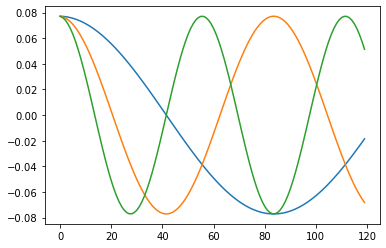

In [19]:
plt.plot(dct_m[1])
plt.plot(dct_m[2])
plt.plot(dct_m[3])

In [25]:
dct2(x)

array([[ 36.74695221,   7.30487901,  -5.39774251, ...,  10.92113668,
         20.13276311,  -6.86842019],
       [ -5.57299668,  22.19710645,  11.38956915, ...,  24.60581128,
        -20.42301093, -17.80969829],
       [  2.14983464, -16.54939237, -14.60065517, ...,   5.12294529,
         10.19979315,  -8.79323345],
       ...,
       [  6.88558823,  -5.92078276,   4.78758929, ...,  -2.87293326,
         13.79791626,   5.45642293],
       [  3.72466301,  25.66418702,   5.30181343, ...,  -1.79285434,
         -2.24397163,  -0.71280847],
       [  6.21353632,   4.17522933, -14.73434864, ...,   1.43051204,
        -11.17132952,  24.98327079]])

In [125]:
(dct(x,norm='ortho')).shape

(4, 6)

In [122]:
(dct2(np.eye(4,6),norm='ortho') @ x.T) 

array([[-0.01187428,  0.49266205, -0.44239569,  0.41618809],
       [ 1.3783358 , -0.45540198, -0.45719863, -0.3717228 ],
       [-0.80666692, -0.84126643,  0.29137023, -1.27114   ],
       [ 0.74931816,  0.44821495, -0.01123526, -0.57684716]])

In [109]:
np.round((dct_mat(x).T[:4,:].T @ x),3).shape

(6, 6)

In [107]:
np.round(dct(x,norm='ortho'),3) == np.round(dct(np.eye(4,6),norm='ortho').T @ x)

C:\Users\MIRPIA~1\AppData\Local\Temp/ipykernel_12196/3591576736.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.round(dct(x,norm='ortho'),3) == np.round(dct(np.eye(4,6),norm='ortho').T @ x)


False

In [100]:
dct(np.eye(4,2),norm='ortho').T @ dct(np.eye(4,2),norm='ortho')

array([[1., 0.],
       [0., 1.]])

In [223]:
(np.random.rand(84,1) @ np.random.rand(1,10)).shape

(84, 10)

In [20]:
dct2(np.eye(8,8),norm='ortho')

array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,
         0.35355339,  0.35355339,  0.35355339],
       [ 0.49039264,  0.41573481,  0.27778512,  0.09754516, -0.09754516,
        -0.27778512, -0.41573481, -0.49039264],
       [ 0.46193977,  0.19134172, -0.19134172, -0.46193977, -0.46193977,
        -0.19134172,  0.19134172,  0.46193977],
       [ 0.41573481, -0.09754516, -0.49039264, -0.27778512,  0.27778512,
         0.49039264,  0.09754516, -0.41573481],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339,
        -0.35355339, -0.35355339,  0.35355339],
       [ 0.27778512, -0.49039264,  0.09754516,  0.41573481, -0.41573481,
        -0.09754516,  0.49039264, -0.27778512],
       [ 0.19134172, -0.46193977,  0.46193977, -0.19134172, -0.19134172,
         0.46193977, -0.46193977,  0.19134172],
       [ 0.09754516, -0.27778512,  0.41573481, -0.49039264,  0.49039264,
        -0.41573481,  0.27778512, -0.09754516]])

In [225]:
sig = dct_mat(x) @ x
sig.shape

(32, 40)

In [226]:
print(np.round(np.transpose(dct_mat(x)) @ dct_mat(x),3))

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ... -0.  0.  0.]
 [ 0.  0.  1. ... -0. -0. -0.]
 ...
 [ 0. -0. -0. ...  1.  0. -0.]
 [ 0.  0. -0. ...  0.  1.  0.]
 [ 0.  0. -0. ... -0.  0.  1.]]


In [ ]:
x_t = torch.tensor(x)
x_t

In [ ]:
x_t.shape[0:2]

In [15]:
dct_m = dct(np.eye(8,8),norm='ortho')

# dct_mat_t = torch.from_numpy(dct_mat)

In [28]:
(np.round(dct_m,3).T)

array([[ 0.354,  0.354,  0.354,  0.354,  0.354,  0.354,  0.354,  0.354],
       [ 0.49 ,  0.416,  0.278,  0.098, -0.098, -0.278, -0.416, -0.49 ],
       [ 0.462,  0.191, -0.191, -0.462, -0.462, -0.191,  0.191,  0.462],
       [ 0.416, -0.098, -0.49 , -0.278,  0.278,  0.49 ,  0.098, -0.416],
       [ 0.354, -0.354, -0.354,  0.354,  0.354, -0.354, -0.354,  0.354],
       [ 0.278, -0.49 ,  0.098,  0.416, -0.416, -0.098,  0.49 , -0.278],
       [ 0.191, -0.462,  0.462, -0.191, -0.191,  0.462, -0.462,  0.191],
       [ 0.098, -0.278,  0.416, -0.49 ,  0.49 , -0.416,  0.278, -0.098]])

In [9]:
F.linear(torch.from_numpy(x),torch.from_numpy(dct_mat))

tensor([[-3.6838,  4.5511, -7.5077,  4.4449,  0.4294, -5.3993, -0.4791,  1.7339],
        [-1.2269,  1.4055, -0.0327, -6.3631, -5.4746, -8.1634, -8.5513, -8.4383],
        [-5.9288, -1.8082,  3.3115,  5.9906, -0.8547,  0.6720, 11.0837,  0.1459],
        [-0.4827,  6.1672,  4.4707,  1.2702,  2.1766, -0.8641,  2.2093,  5.8620],
        [ 2.6100,  0.3640,  1.7039, -0.1384,  2.8597,  3.4865, -7.2370,  3.6523],
        [-2.0381, -3.2484, -8.8378, -6.0198, -0.7807,  0.6358,  1.4775, -0.4439],
        [ 0.1965,  1.1532,  0.7930,  5.7270, -1.2698, -0.3852,  2.8126, -2.2283],
        [ 8.1541,  3.6669, -0.9545, -2.3249,  1.0171,  1.3197,  2.8246, -0.2035]],
       dtype=torch.float64)

In [ ]:
w = nn.Linear(x.shape[-1],dct_mat.shape[-1])
w

In [ ]:
x_t.float()

In [ ]:
w(x_t.float())

In [ ]:
nn.Parameter(torch.matmul(x_t,dct_mat_t)).shape

In [ ]:
dct(x)

In [ ]:
dct2(np.eye(256,256))

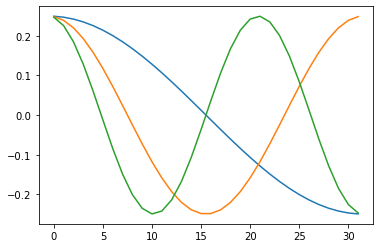

In [228]:
plt.plot(dct_mat(x)[1])
plt.plot(dct_mat(x)[2])
plt.plot(dct_mat(x)[3])

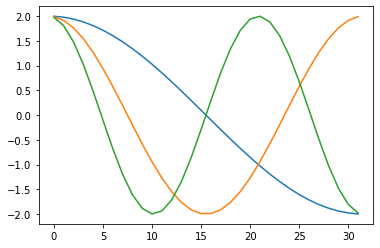

In [227]:
# plt.figure()
plt.plot(dct2(np.eye(32,32))[1])
plt.plot(dct2(np.eye(32,32))[2])
plt.plot(dct2(np.eye(32,32))[3])

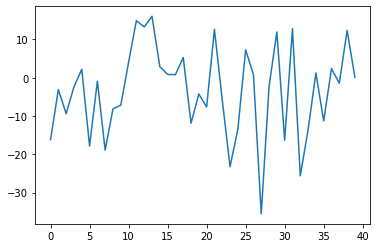

In [230]:
plt.plot((dct2(x)[0]))

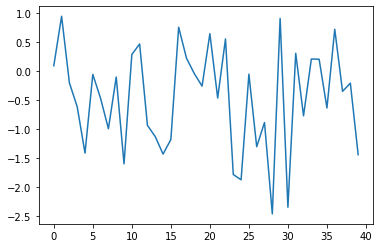

In [231]:
plt.plot(x[0])

In [ ]:
dct2(x, norm='ortho') - dct(x,2, axis=0, norm='ortho')